In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/colon-dataset/README.dataset.txt
/kaggle/input/colon-dataset/README.roboflow.txt
/kaggle/input/colon-dataset/valid/normal_good/58_png.rf.0e30136e3ba7922f249238a08488eb0d.jpg
/kaggle/input/colon-dataset/valid/normal_good/321_png.rf.d16cbbf5d9fcdae0ac4ec1d6d42b62c7.jpg
/kaggle/input/colon-dataset/valid/normal_good/lower-third_png.rf.c9de0c02180db636638a8ebd068dcab3.jpg
/kaggle/input/colon-dataset/valid/normal_good/320_png.rf.e03d16dc7ad96c7d3af4245e7a1de32b.jpg
/kaggle/input/colon-dataset/valid/normal_good/143_png.rf.3f92d53c73390ff6ec2f2de96c1b1aaa.jpg
/kaggle/input/colon-dataset/valid/normal_good/361_png.rf.89097421dd41190f16ade5ffe4dfa717.jpg
/kaggle/input/colon-dataset/valid/normal_good/d3_png.rf.77a1c0d906c719f75af744a53e5824e6.jpg
/kaggle/input/colon-dataset/valid/normal_good/a14_png.rf.131de8dfac6df493f8c372bf4747f8c5.jpg
/kaggle/input/colon-dataset/valid/normal_good/385_png.rf.add7fe20eae4a95191fcaceb8e34b37c.jpg
/kaggle/input/colon-dataset/valid/normal_good/260_png

In [2]:
# Step 0: Setup & config
import os, random, math
from pathlib import Path
import numpy as np

# ⚠️ Update this path to your Kaggle dataset folder (the one containing train/valid(or val)/test)
DATA_DIR = "/kaggle/input/colon-dataset"

IMG_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 15
LR = 3e-4
SEED = 42

# Reproducibility
import torch
import torch.backends.cudnn as cudnn
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
cudnn.deterministic = True; cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Check dataset structure
root = Path(DATA_DIR)
assert root.exists(), f"DATA_DIR not found: {root}"

candidates = ["train", "valid", "val", "test"]
present = [d for d in candidates if (root/d).exists()]
print("Top-level splits found:", present)

assert ("train" in present) and (("valid" in present) or ("val" in present)) and ("test" in present), \
       "Expected train/valid(or val)/test folders."

VAL_NAME = "valid" if (root/"valid").exists() else "val"
print("✅ Step 0 OK — paths exist and splits detected:", f"val split='{VAL_NAME}'")


Device: cuda
Top-level splits found: ['train', 'valid', 'test']
✅ Step 0 OK — paths exist and splits detected: val split='valid'


In [3]:
# Step 0a — Verify split sizes (expecting about 80/10/10)

def count_all_images(folder: Path):
    exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}
    if not folder.exists():
        return 0
    total = 0
    for cls in folder.iterdir():
        if cls.is_dir():
            total += sum(1 for p in cls.rglob("*") if p.suffix.lower() in exts)
    return total

train_n = count_all_images(root/"train")
val_n   = count_all_images(root/"valid")
test_n  = count_all_images(root/"test")
total_n = train_n + val_n + test_n

print(f"Counts -> train: {train_n}, valid: {val_n}, test: {test_n}, total: {total_n}")

ratio_train = train_n / max(total_n, 1)
ratio_val   = val_n   / max(total_n, 1)
ratio_test  = test_n  / max(total_n, 1)

print(f"Ratios -> train: {ratio_train:.3f}, valid: {ratio_val:.3f}, test: {ratio_test:.3f}")

# Check ratios ~80/10/10
assert abs(ratio_train-0.80) <= 0.05 and abs(ratio_val-0.10) <= 0.05 and abs(ratio_test-0.10) <= 0.05, \
    "Split ratios are not close to 80/10/10 — please re-check dataset."

print("✅ Step 0a OK — split sizes look correct.")


Counts -> train: 494, valid: 62, test: 62, total: 618
Ratios -> train: 0.799, valid: 0.100, test: 0.100
✅ Step 0a OK — split sizes look correct.


In [4]:
# Step 1 — Inspect classes & per-split counts

from collections import Counter
from pathlib import Path

def list_classes(split_dir: Path):
    classes = sorted([d.name for d in split_dir.iterdir() if d.is_dir()])
    assert classes, f"No class folders under {split_dir}"
    return classes

def count_by_class(split_dir: Path, classes):
    exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}
    counts = {}
    for c in classes:
        cdir = split_dir / c
        n = sum(1 for p in cdir.rglob("*") if p.suffix.lower() in exts)
        counts[c] = n
    return counts

train_dir = root / "train"
valid_dir = root / "valid"
test_dir  = root / "test"

classes = list_classes(train_dir)
num_classes = len(classes)
print(f"Classes ({num_classes}):", classes)

# class→idx will be folder order
class_to_idx = {c: i for i, c in enumerate(classes)}
print("Class → idx mapping:", class_to_idx)

train_counts = count_by_class(train_dir, classes)
valid_counts = count_by_class(valid_dir, classes)
test_counts  = count_by_class(test_dir,  classes)

print("\nPer-class counts:")
print("TRAIN:", train_counts)
print("VALID:", valid_counts)
print("TEST :", test_counts)

# sanity checks
assert all(train_counts[c] > 0 for c in classes), "Empty class in TRAIN"
assert all(valid_counts[c] > 0 for c in classes), "Empty class in VALID"
assert all(test_counts[c]  > 0 for c in classes), "Empty class in TEST"

# quick imbalance signal
import numpy as np
train_vals = np.array(list(train_counts.values()))
imb_ratio = train_vals.max() / max(1, train_vals.min())
print(f"\nImbalance ratio (max/min in TRAIN): {imb_ratio:.2f}x")

print("✅ Step 1 OK — classes discovered, counts printed, no empty classes.")


Classes (2): ['cancer_good', 'normal_good']
Class → idx mapping: {'cancer_good': 0, 'normal_good': 1}

Per-class counts:
TRAIN: {'cancer_good': 181, 'normal_good': 313}
VALID: {'cancer_good': 35, 'normal_good': 27}
TEST : {'cancer_good': 23, 'normal_good': 39}

Imbalance ratio (max/min in TRAIN): 1.73x
✅ Step 1 OK — classes discovered, counts printed, no empty classes.


class_to_idx: {'cancer_good': 0, 'normal_good': 1}
Batch shape: (32, 3, 224, 224) | Labels shape: (32,)


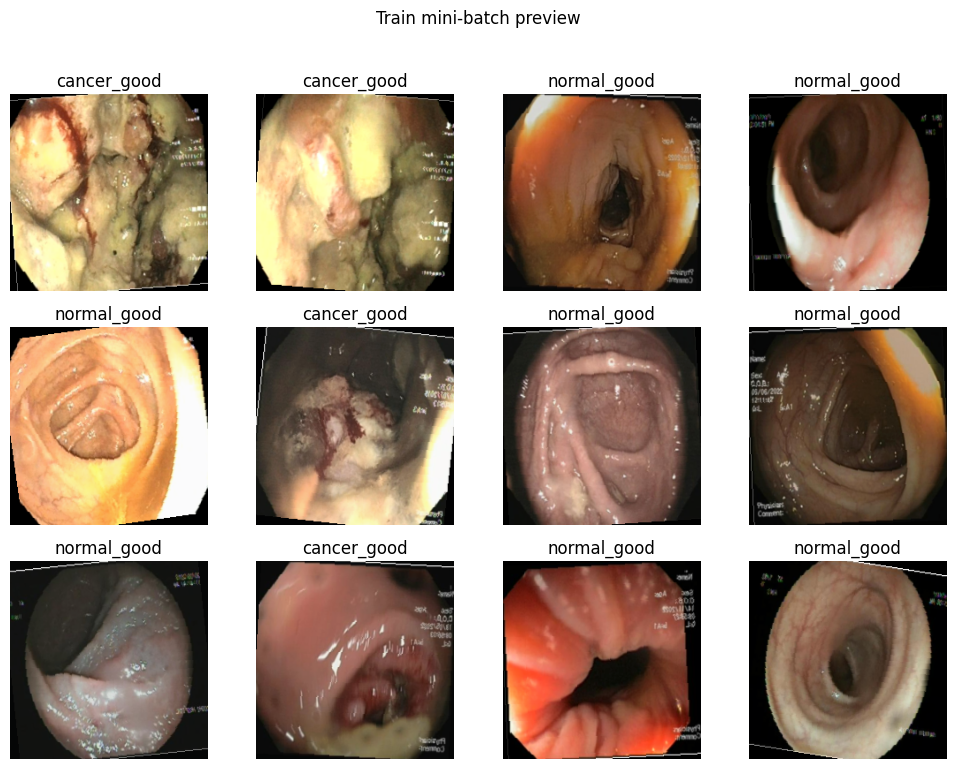

✅ Step 2 OK — datasets & loaders ready, preview displayed.


In [5]:
# Step 2 — Datasets, DataLoaders, and a preview grid

import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import math
import torch

# ----- Transforms -----
IMG_SIZE = IMG_SIZE  # from Step 0 config
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.10, contrast=0.10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# ----- Datasets -----
train_ds = torchvision.datasets.ImageFolder(str(train_dir), transform=train_tfms)
valid_ds = torchvision.datasets.ImageFolder(str(valid_dir), transform=eval_tfms)
test_ds  = torchvision.datasets.ImageFolder(str(test_dir),  transform=eval_tfms)

# Ensure class-to-index mapping is consistent and matches Step 1
assert list(train_ds.class_to_idx.keys()) == classes, "Class order mismatch vs Step 1"
assert train_ds.class_to_idx == valid_ds.class_to_idx == test_ds.class_to_idx, "Inconsistent class_to_idx across splits"
print("class_to_idx:", train_ds.class_to_idx)

# ----- DataLoaders -----
BATCH_SIZE = BATCH_SIZE if 'BATCH_SIZE' in globals() else 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# ----- Visual preview -----
def unnormalize(img_tensor):
    mean = np.array([0.485,0.456,0.406])
    std  = np.array([0.229,0.224,0.225])
    img = img_tensor.detach().cpu().numpy().transpose(1,2,0)
    img = (img * std + mean).clip(0,1)
    return img

images, labels = next(iter(train_loader))
print("Batch shape:", tuple(images.shape), "| Labels shape:", tuple(labels.shape))

def show_grid(imgs, lbls, n=12):
    n = min(n, imgs.size(0))
    cols = 4
    rows = int(math.ceil(n/cols))
    plt.figure(figsize=(10, 2.5*rows))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        plt.imshow(unnormalize(imgs[i]))
        plt.title(classes[lbls[i].item()])
        plt.axis('off')
    plt.suptitle("Train mini-batch preview", y=1.02)
    plt.tight_layout()
    plt.show()

show_grid(images, labels, n=12)

print("✅ Step 2 OK — datasets & loaders ready, preview displayed.")


In [8]:
# Step 3 (ALT, FIXED) — Fine-tune a pretrained EfficientNet-B0 (robust to torchvision versions)

import time, numpy as np, torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# ---- Model & weights ----
weights = EfficientNet_B0_Weights.DEFAULT
model = efficientnet_b0(weights=weights)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, len(classes))
model = model.to(device)

# Try to get normalization from weights; fallback to ImageNet defaults
try:
    # In some versions, these aren't in .meta; try transform object first
    tfms = weights.transforms()
    # Find Normalize in the composed transforms
    norm_mean, norm_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    for t in getattr(tfms, 'transforms', []):
        if isinstance(t, __import__('torchvision').transforms.Normalize):
            norm_mean, norm_std = list(t.mean), list(t.std)
            break
except Exception:
    # Absolute fallback
    norm_mean, norm_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

print("Using normalization:", {"mean": norm_mean, "std": norm_std})

# ---- Class weights (inverse frequency, normalized) ----
label_list = [y for _, y in train_ds.samples]
counts = np.bincount(label_list, minlength=len(classes)).astype(np.float32)
N = counts.sum()
class_weights = (N / (len(classes) * counts))
class_weights = class_weights / class_weights.mean()
weight_tensor = torch.tensor(class_weights, dtype=torch.float32, device=device)
print("Class counts:", dict(zip(classes, counts.tolist())))
print("Class weights:", dict(zip(classes, class_weights.round(4).tolist())))

criterion = nn.CrossEntropyLoss(weight=weight_tensor)

# Slightly lower LR for fine-tuning
optimizer = torch.optim.AdamW(model.parameters(), lr=min(1e-4, LR))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2, verbose=True)

# Use the new AMP API to avoid deprecation warnings
from torch.amp import GradScaler, autocast
scaler = GradScaler('cuda', enabled=(device.type=="cuda"))

# (Optional) warm-up: freeze backbone for 1 epoch, then unfreeze
for p in model.features.parameters():
    p.requires_grad = False
frozen_epochs = 1

def accuracy_from_logits(logits, t):
    return (logits.argmax(1) == t).float().mean().item()

def run_epoch(loader, train_mode=True):
    model.train(mode=train_mode)
    total_loss = total_acc = total_n = 0
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        if train_mode:
            optimizer.zero_grad(set_to_none=True)
        with torch.set_grad_enabled(train_mode), autocast('cuda', enabled=(device.type=="cuda")):
            logits = model(xb)
            loss = criterion(logits, yb)
        if train_mode:
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            scaler.step(optimizer)
            scaler.update()
        bs = xb.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy_from_logits(logits, yb) * bs
        total_n    += bs
    return total_loss / max(total_n,1), total_acc / max(total_n,1)

best_val_acc, best_path, patience, no_improve = 0.0, "best_cnn.pth", 6, 0
print("\nStarting fine-tuning…")

for epoch in range(1, NUM_EPOCHS + 1):
    # unfreeze after warm-up
    if epoch == frozen_epochs + 1:
        for p in model.features.parameters():
            p.requires_grad = True
        print("🧊→🔥 Unfroze backbone (full fine-tuning).")

    t0 = time.time()
    train_loss, train_acc = run_epoch(train_loader, True)
    val_loss,   val_acc   = run_epoch(valid_loader, False)
    scheduler.step(val_acc)
    dt = time.time() - t0

    print(f"Epoch {epoch:02d}/{NUM_EPOCHS} | "
          f"train_loss {train_loss:.4f} acc {train_acc:.4f} | "
          f"val_loss {val_loss:.4f} acc {val_acc:.4f} | {dt:.1f}s")

    if val_acc > best_val_acc + 1e-4:
        best_val_acc = val_acc; no_improve = 0
        torch.save({
            "state_dict": model.state_dict(),
            "classes": classes,
            "img_size": IMG_SIZE,
            "class_to_idx": train_ds.class_to_idx,
            "norm_mean": norm_mean,
            "norm_std":  norm_std,
        }, best_path)
        print(f"  ✅ Saved new best model: {best_val_acc:.4f}")
    else:
        no_improve += 1
        if no_improve >= patience:
            print("  ⛔ Early stopping — no val acc improvement")
            break

assert Path(best_path).exists(), "Training ended without saving a best model."
print("✅ Step 3 OK — best model saved to", best_path)


Using normalization: {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}
Class counts: {'cancer_good': 181.0, 'normal_good': 313.0}
Class weights: {'cancer_good': 1.267199993133545, 'normal_good': 0.7328000068664551}

Starting fine-tuning…
Epoch 01/15 | train_loss 0.7034 acc 0.6093 | val_loss 0.6596 acc 0.5968 | 2.5s
  ✅ Saved new best model: 0.5968
🧊→🔥 Unfroze backbone (full fine-tuning).
Epoch 02/15 | train_loss 0.5007 acc 0.8623 | val_loss 0.2376 acc 0.9839 | 3.4s
  ✅ Saved new best model: 0.9839
Epoch 03/15 | train_loss 0.2003 acc 0.9676 | val_loss 0.0641 acc 1.0000 | 2.8s
  ✅ Saved new best model: 1.0000
Epoch 04/15 | train_loss 0.0944 acc 0.9818 | val_loss 0.0312 acc 1.0000 | 2.7s
Epoch 05/15 | train_loss 0.0389 acc 0.9980 | val_loss 0.0374 acc 0.9839 | 2.8s
Epoch 06/15 | train_loss 0.0260 acc 0.9960 | val_loss 0.0269 acc 0.9839 | 2.7s
Epoch 07/15 | train_loss 0.0310 acc 0.9939 | val_loss 0.0221 acc 1.0000 | 2.7s
Epoch 08/15 | train_loss 0.0258 acc 0.9960 | val_loss 0.0

Classification report (TEST):
              precision    recall  f1-score   support

 cancer_good     0.9565    0.9565    0.9565        23
 normal_good     0.9744    0.9744    0.9744        39

    accuracy                         0.9677        62
   macro avg     0.9654    0.9654    0.9654        62
weighted avg     0.9677    0.9677    0.9677        62



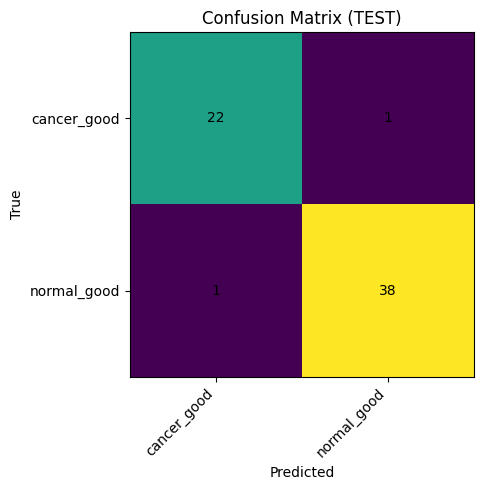

Showing up to 8 misclassified images (found 2):


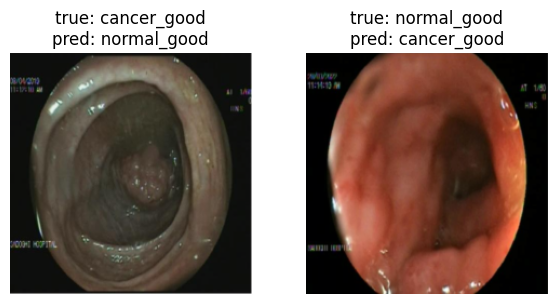

✅ Step 4 OK — test metrics printed, confusion matrix drawn.


In [9]:
# Step 4 — Evaluate on TEST set (report + confusion matrix + sample errors)

import torch, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

ckpt = torch.load("best_cnn.pth", map_location=device)
model.load_state_dict(ckpt["state_dict"])
model.eval()

# use saved normalization info (already baked into transforms earlier, but we’ll keep for display)
norm_mean = ckpt.get("norm_mean", [0.485,0.456,0.406])
norm_std  = ckpt.get("norm_std",  [0.229,0.224,0.225])

all_preds, all_labels = [], []
all_paths = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())

all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)

print("Classification report (TEST):")
print(classification_report(all_labels, all_preds, target_names=classes, digits=4))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
plt.imshow(cm)
plt.title("Confusion Matrix (TEST)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(ticks=np.arange(len(classes)), labels=classes, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(classes)), labels=classes)
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, int(v), ha='center', va='center')
plt.tight_layout(); plt.show()

# Show up to 8 misclassified samples (if any)
# (We rebuild a lightweight iterator to capture file paths)
mis_idx = []
if hasattr(test_ds, 'samples'):
    # re-run a single pass to capture file paths aligned with predictions
    all_preds, all_labels, all_paths = [], [], []
    with torch.no_grad():
        for (paths, yb_idx) in [( [p for p,_ in test_ds.samples[i:i+BATCH_SIZE]], 
                                  torch.tensor([y for _,y in test_ds.samples[i:i+BATCH_SIZE]])) 
                                 for i in range(0, len(test_ds.samples), BATCH_SIZE)]:
            # load tensors via test_loader logic for correctness
            # (but ImageFolder handles transform internally; we’ll just index directly)
            # Simplify: create a small batch manually
            xb = torch.stack([test_ds[i][0] for i in range(len(all_paths), len(all_paths)+len(paths))]).to(device)
            logits = model(xb)
            preds = logits.argmax(1).cpu().numpy()
            all_preds.extend(preds); 
            all_labels.extend(yb_idx.numpy()); 
            all_paths.extend(paths)

    all_preds  = np.array(all_preds); 
    all_labels = np.array(all_labels)
    mis_idx = np.where(all_preds != all_labels)[0].tolist()

if len(mis_idx) == 0:
    print("No misclassifications found on TEST set 🎉")
else:
    print(f"Showing up to 8 misclassified images (found {len(mis_idx)}):")
    import math
    cols = 4
    nshow = min(8, len(mis_idx))
    rows = int(math.ceil(nshow/cols))
    plt.figure(figsize=(12, 3*rows))
    for k in range(nshow):
        i = mis_idx[k]
        img, _ = test_ds[i]
        # unnormalize for display
        img_np = img.numpy().transpose(1,2,0)
        img_np = (img_np * np.array(norm_std) + np.array(norm_mean)).clip(0,1)
        plt.subplot(rows, cols, k+1)
        plt.imshow(img_np)
        plt.title(f"true: {classes[all_labels[i]]}\npred: {classes[all_preds[i]]}")
        plt.axis('off')
    plt.tight_layout(); plt.show()

print("✅ Step 4 OK — test metrics printed, confusion matrix drawn.")


In [10]:
# Step 5 — Inference helper (single image)

from PIL import Image

def predict_image(path, model, classes, device=device):
    model.eval()
    img = Image.open(path).convert("RGB")
    # Apply the same normalization
    tfms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=norm_mean, std=norm_std),
    ])
    x = tfms(img).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]

    pred_idx = int(np.argmax(probs))
    return classes[pred_idx], float(probs[pred_idx]), {classes[i]: float(probs[i]) for i in range(len(classes))}

# Example usage — pick one test image
example_path, _ = test_ds.samples[0]
pred_label, conf, dist = predict_image(example_path, model, classes)
print("Example:", example_path)
print("Predicted:", pred_label, f"({conf:.3f} confidence)")
print("Probabilities:", dist)

print("✅ Step 5 OK — inference helper works.")


Example: /kaggle/input/colon-dataset/test/cancer_good/2_png.rf.77976fb40d53a118af0825f547d64fd0.jpg
Predicted: cancer_good (0.953 confidence)
Probabilities: {'cancer_good': 0.9525660276412964, 'normal_good': 0.047433964908123016}
✅ Step 5 OK — inference helper works.


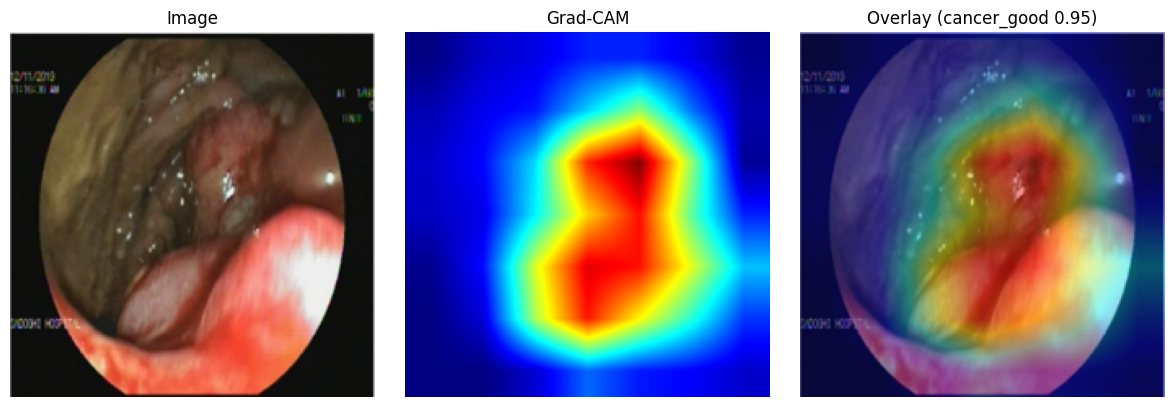

✅ Step 6 OK — Grad-CAM visualized.


In [11]:
# Step 6 — Grad-CAM (auto-detect last Conv2d layer) + overlay visualization

import torch, numpy as np, matplotlib.pyplot as plt, cv2
from PIL import Image
from torchvision import transforms

model.eval()

# --- find last Conv2d layer in the model ---
last_conv = None
for m in model.modules():
    if isinstance(m, torch.nn.Conv2d):
        last_conv = m
assert last_conv is not None, "No Conv2d layer found for Grad-CAM."

acts = []
grads = []

def fwd_hook(_, __, output):
    acts.append(output.detach())

def bwd_hook(_, grad_in, grad_out):
    grads.append(grad_out[0].detach())

h1 = last_conv.register_forward_hook(fwd_hook)
h2 = last_conv.register_full_backward_hook(bwd_hook)  # works for PyTorch>=1.8

# same normalization as training
tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=norm_mean, std=norm_std),
])

def gradcam_on_image(img_path, target_class=None, alpha=0.35):
    # load image
    pil = Image.open(img_path).convert("RGB")
    x = tfms(pil).unsqueeze(0).to(device)

    # forward pass
    acts.clear(); grads.clear()
    logits = model(x)
    probs = torch.softmax(logits, dim=1)[0].detach().cpu().numpy()
    pred_idx = int(np.argmax(probs))
    if target_class is None:
        target_class = pred_idx

    # backward on target logit
    model.zero_grad(set_to_none=True)
    logits[0, target_class].backward()

    A = acts[-1].squeeze(0)        # [C, H, W]
    G = grads[-1].squeeze(0)       # [C, H, W]
    # weights: global-average-pool of gradients
    weights = G.mean(dim=(1,2))    # [C]
    # Grad-CAM
    cam = torch.relu((weights[:, None, None] * A).sum(dim=0))  # [H, W]
    cam = cam / (cam.max() + 1e-8)
    cam = cam.cpu().numpy()

    # upscale CAM to image size
    cam_up = cv2.resize(cam, (IMG_SIZE, IMG_SIZE))
    heatmap = (255 * cam_up).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)[:, :, ::-1]  # BGR->RGB

    # original (unnormalized) image for display
    disp = np.array(pil.resize((IMG_SIZE, IMG_SIZE)))
    overlay = (alpha * heatmap + (1 - alpha) * disp).astype(np.uint8)

    return {
        "pred_label": classes[pred_idx],
        "pred_conf": float(probs[pred_idx]),
        "target_label": classes[target_class],
        "probs": {classes[i]: float(probs[i]) for i in range(len(classes))},
        "disp": disp, "heatmap": heatmap, "overlay": overlay
    }

# --- demo on one test image ---
example_path, _ = test_ds.samples[0]
out = gradcam_on_image(example_path, target_class=None, alpha=0.40)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(out["disp"]);    plt.title("Image");   plt.axis('off')
plt.subplot(1,3,2); plt.imshow(out["heatmap"]); plt.title("Grad-CAM");plt.axis('off')
plt.subplot(1,3,3); plt.imshow(out["overlay"]); plt.title(f"Overlay ({out['pred_label']} {out['pred_conf']:.2f})"); plt.axis('off')
plt.tight_layout(); plt.show()

print("✅ Step 6 OK — Grad-CAM visualized.")


Confusion Matrix:
[[22  1]
 [ 1 38]]
Sensitivity (Recall cancer): 0.974
Specificity (Recall normal): 0.957
PPV (Precision cancer): 0.974
NPV (Precision normal): 0.957
Accuracy: 0.968

95% CI estimates:
Accuracy: (0.8897953040501456, 0.9911086285001833)
Sensitivity: (0.8681900983014992, 0.9954592968990099)
Specificity: (0.7900884492974111, 0.9922833338565468)


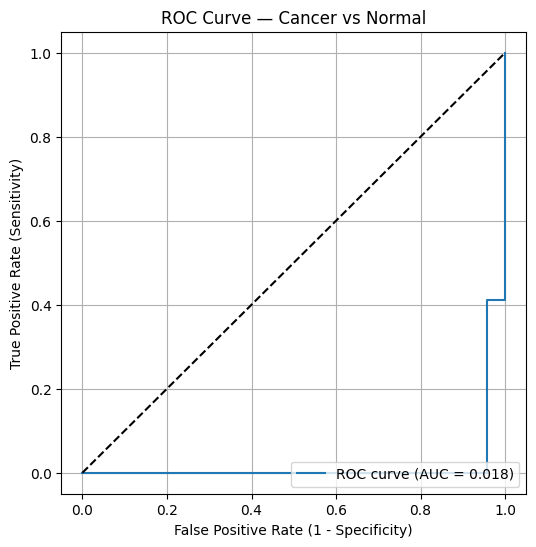

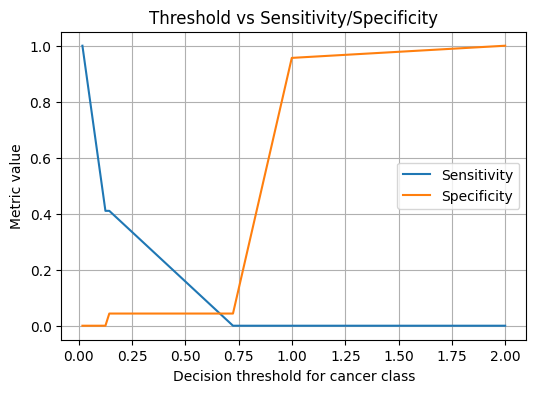

✅ Step 6b OK — sensitivity, specificity, PPV, NPV, ROC, CIs computed.


In [12]:
# Step 6b — Clinical evaluation metrics: Sensitivity, Specificity, PPV, NPV, ROC, CIs

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from statsmodels.stats.proportion import proportion_confint

# --- collect raw outputs on TEST ---
all_logits, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        all_logits.append(logits.cpu().numpy())
        all_labels.extend(yb.numpy())
all_logits = np.concatenate(all_logits, axis=0)
all_labels = np.array(all_labels)

probs = torch.softmax(torch.tensor(all_logits), dim=1).numpy()
preds = np.argmax(probs, axis=1)

# --- confusion matrix ---
cm = confusion_matrix(all_labels, preds)
tn, fp, fn, tp = cm.ravel()
print("Confusion Matrix:")
print(cm)

# --- metrics ---
sensitivity = tp / (tp + fn) if (tp+fn)>0 else 0
specificity = tn / (tn + fp) if (tn+fp)>0 else 0
ppv = tp / (tp + fp) if (tp+fp)>0 else 0
npv = tn / (tn + fn) if (tn+fn)>0 else 0
acc = (tp + tn) / (tp + tn + fp + fn)

print(f"Sensitivity (Recall cancer): {sensitivity:.3f}")
print(f"Specificity (Recall normal): {specificity:.3f}")
print(f"PPV (Precision cancer): {ppv:.3f}")
print(f"NPV (Precision normal): {npv:.3f}")
print(f"Accuracy: {acc:.3f}")

# --- 95% confidence intervals (Wilson) ---
def ci_wilson(k, n, alpha=0.05):
    low, high = proportion_confint(k, n, alpha=alpha, method="wilson")
    return (low, high)

print("\n95% CI estimates:")
print("Accuracy:", ci_wilson(tp+tn, len(all_labels)))
print("Sensitivity:", ci_wilson(tp, tp+fn))
print("Specificity:", ci_wilson(tn, tn+fp))

# --- ROC curve ---
fpr, tpr, thresholds = roc_curve(all_labels, probs[:, classes.index("cancer_good")])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve — Cancer vs Normal")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# --- Threshold exploration ---
plt.figure(figsize=(6,4))
plt.plot(thresholds, tpr, label="Sensitivity")
plt.plot(thresholds, 1-fpr, label="Specificity")
plt.xlabel("Decision threshold for cancer class")
plt.ylabel("Metric value")
plt.title("Threshold vs Sensitivity/Specificity")
plt.legend()
plt.grid(True)
plt.show()

print("✅ Step 6b OK — sensitivity, specificity, PPV, NPV, ROC, CIs computed.")
